In [1]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/skin_lession_classification'
ZIP_PATH = os.path.join(DRIVE_PROJECT_PATH, 'dataset.zip')

if not os.path.exists('/content/dataset'):
    print("Veri seti açılıyor")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("BAŞARILI! Veri seti '/content/dataset' klasörüne açıldı.")
else:
    print("Veri seti zaten hazır.")

Mounted at /content/drive
Veri seti açılıyor
BAŞARILI! Veri seti '/content/dataset' klasörüne açıldı.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Eğitim şu cihazda yapılacak: {device}")

DATA_DIR = '/content/dataset'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print(f"Sınıflar: {CLASSES}")

Eğitim şu cihazda yapılacak: cuda:0
Sınıflar: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [3]:
print("--- 1. Deep Learning (ResNet50) Ablasyon Çalışması Başlıyor ---")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 1.a Ablasyon Çalışması (Weighted Loss)
# sinif sayilarini hesapliyoruz
class_counts = []
for x in ['train']:
    targets = image_datasets[x].targets
    counts = np.bincount(targets)
    class_counts = counts

# Ağırlık hesabı: (Toplam Örnek / (Sınıf Sayısı * Sınıf Frekansı))
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print(f"Hesaplanan Sınıf Ağırlıkları: {class_weights}")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(CLASSES))
model = model.to(device)

# 1.a Ablasyon loss fonksiyonu olarak weighted loss kullaniyoruz
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Baseline: optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 1.b Ablasyon optimizer olarak Adam kullaniyoruz (SGD ye gore daha hizli yakinsar, daha dusuk lr kullaniyoruz.)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

rn50_train_losses, rn50_val_losses = [], []
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs} başlıyor...')

    for phase in ['train', 'val']:
        if phase == 'train': model.train()
        else: model.eval()

        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(dataloaders[phase], desc=f'{phase} Phase', leave=True)

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            current_loss = running_loss / ((pbar.n + 1) * inputs.size(0)) if pbar.n > 0 else loss.item()
            pbar.set_postfix({'loss': f'{current_loss:.4f}'})

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train': rn50_train_losses.append(epoch_loss)
        else: rn50_val_losses.append(epoch_loss)

save_path = os.path.join(DRIVE_PROJECT_PATH, 'resnet50_d2_model.pth')
torch.save(model.state_dict(), save_path)
print(f"\nModel başarıyla kaydedildi: {save_path}")

--- 1. Deep Learning (ResNet50) Ablasyon Çalışması Başlıyor ---
Hesaplanan Sınıf Ağırlıkları: tensor([0.1347, 0.0859, 0.0401, 0.3836, 0.0396, 0.0066, 0.3095],
       device='cuda:0')
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


Epoch 1/5 başlıyor...


train Phase:   0%|          | 0/251 [02:33<?, ?it/s, loss=1.0233]

TRAIN Loss: 1.2669 Acc: 0.6395



train Phase:   0%|          | 0/251 [02:33<?, ?it/s, loss=1.0233]

val Phase:   0%|          | 0/32 [00:11<?, ?it/s, loss=0.4043]

VAL Loss: 0.8636 Acc: 0.7153
Epoch 2/5 başlıyor...


train Phase:   0%|          | 0/251 [02:25<?, ?it/s, loss=1.5430]

TRAIN Loss: 0.7446 Acc: 0.7305



train Phase:   0%|          | 0/251 [02:25<?, ?it/s, loss=1.5430]

val Phase:   0%|          | 0/32 [00:11<?, ?it/s, loss=0.5049]

VAL Loss: 0.6807 Acc: 0.7293
Epoch 3/5 başlıyor...


train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=1.3046]

TRAIN Loss: 0.5416 Acc: 0.7673



train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=1.3046]

val Phase:   0%|          | 0/32 [00:11<?, ?it/s, loss=0.2874]

VAL Loss: 0.7744 Acc: 0.7353
Epoch 4/5 başlıyor...


train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=0.3649]

TRAIN Loss: 0.4420 Acc: 0.7961



train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=0.3649]

val Phase:   0%|          | 0/32 [00:16<?, ?it/s, loss=0.2100]

VAL Loss: 0.5530 Acc: 0.7992
Epoch 5/5 başlıyor...


train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=0.3006]

TRAIN Loss: 0.3571 Acc: 0.8323



train Phase:   0%|          | 0/251 [02:24<?, ?it/s, loss=0.3006]

val Phase:   0%|          | 0/32 [00:11<?, ?it/s, loss=0.2178]

VAL Loss: 0.5332 Acc: 0.8042

Model başarıyla kaydedildi: /content/drive/MyDrive/skin_lession_classification/resnet50_d2_model.pth


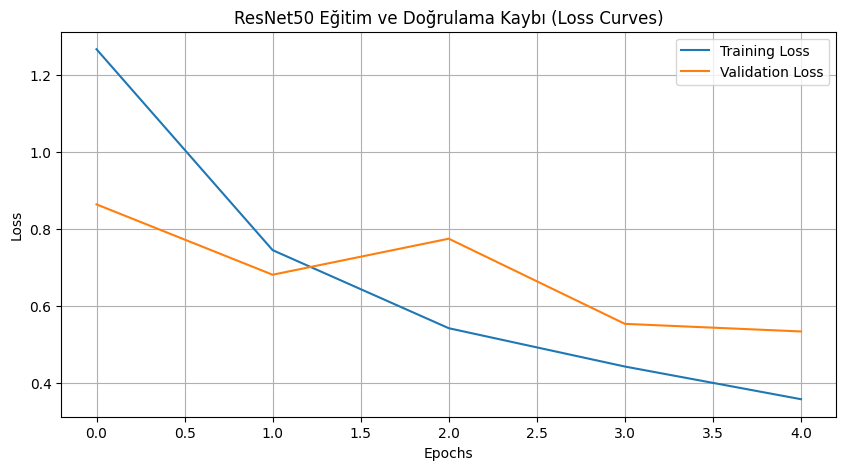

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(rn50_train_losses, label='Training Loss')
plt.plot(rn50_val_losses, label='Validation Loss')
plt.title('ResNet50 Eğitim ve Doğrulama Kaybı (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

![alt text](../output/figures/resnet50_train_val_loss.png "resnet-50-train-val-loss-image")

--- ResNet50 Test Seti Performans Analizi ---
Test seti üzerinde tahmin yapılıyor...

>>> ResNet50 Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       akiec       0.47      0.84      0.60        32
         bcc       0.75      0.81      0.78        52
         bkl       0.51      0.78      0.62       110
          df       0.50      1.00      0.67        11
         mel       0.65      0.62      0.64       112
          nv       0.97      0.82      0.89       671
        vasc       0.54      0.93      0.68        14

    accuracy                           0.80      1002
   macro avg       0.63      0.83      0.70      1002
weighted avg       0.84      0.80      0.81      1002



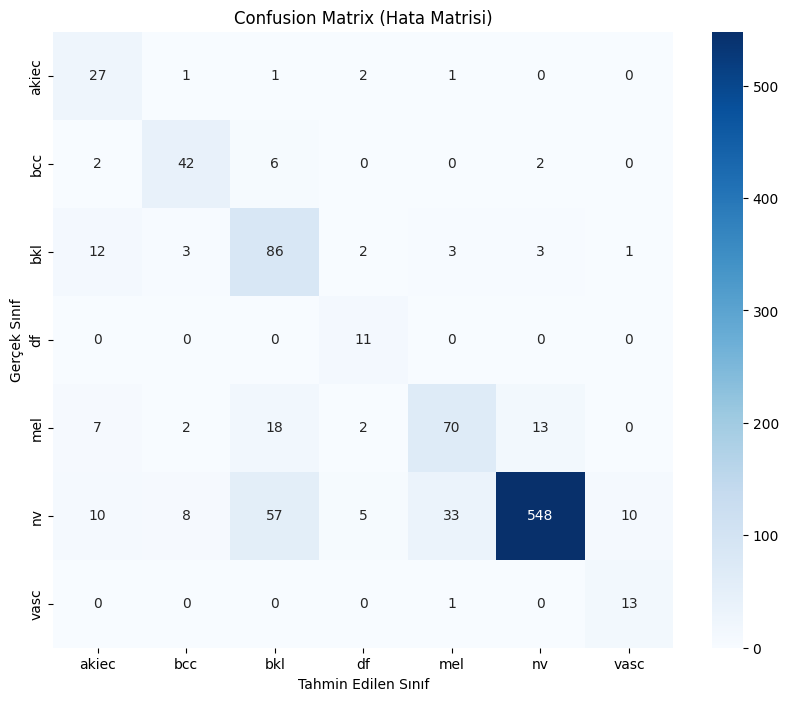

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("--- ResNet50 Test Seti Performans Analizi ---")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
y_true = []
y_pred = []

print("Test seti üzerinde tahmin yapılıyor...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\n>>> ResNet50 Detaylı Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Hata Matrisi)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()


>>> ResNet50 Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       akiec       0.80      0.50      0.62        32
         bcc       0.85      0.65      0.74        52
         bkl       0.78      0.73      0.75       110
          df       0.67      0.55      0.60        11
         mel       0.81      0.49      0.61       112
          nv       0.88      0.99      0.93       671
        vasc       1.00      0.86      0.92        14

    accuracy                           0.86      1002
   macro avg       0.83      0.68      0.74      1002
weighted avg       0.86      0.86      0.85      1002

![alt text](../output/figures/resnet50_conf_matrix.png "resnet-50-conf-matrix-image")

In [6]:
print("--- 2. DL Model: Vision Transformer (ViT-B/16) Ablasyon Çalışması Başlıyor ---")

model_vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

num_ftrs = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(num_ftrs, len(CLASSES))

model_vit = model_vit.to(device)

# 2.a Ablasyon loss fonksiyonu olarak CrossEntropyLoss kullaniyoruz (Weighted Loss)
criterion = nn.CrossEntropyLoss(weight=class_weights) #class_weights'i yukarida hesapladik

# 2.b Ablasyon optimizer olarak SGD kullaniyoruz (ViT için Learning Rate biraz daha düşük olabilir)
#baseline: optim.SGD(model_vit.parameters(), lr=0.001, momentum=0.9)
optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.0001)

vit_train_losses, vit_val_losses = [], []
num_epochs = 5

for epoch in range(num_epochs):
    print(f'ViT Epoch {epoch+1}/{num_epochs} başlıyor...')

    for phase in ['train', 'val']:
        if phase == 'train': model_vit.train()
        else: model_vit.eval()

        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(dataloaders[phase], desc=f'{phase} Phase', leave=True)

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_vit.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_vit(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer_vit.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            current_loss = running_loss / ((pbar.n + 1) * inputs.size(0)) if pbar.n > 0 else loss.item()
            pbar.set_postfix({'loss': f'{current_loss:.4f}'})

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'   {phase.upper()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train': vit_train_losses.append(epoch_loss)
        else: vit_val_losses.append(epoch_loss)

#save
torch.save(model_vit.state_dict(), os.path.join(DRIVE_PROJECT_PATH, 'vit_b16_d2_model.pth'))
print("ViT Modeli Kaydedildi!")

--- 2. DL Model: Vision Transformer (ViT-B/16) Ablasyon Çalışması Başlıyor ---
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 178MB/s]


ViT Epoch 1/5 başlıyor...


train Phase:   0%|          | 0/251 [05:29<?, ?it/s, loss=0.7436]

   TRAIN Loss: 1.4513 Acc: 0.4754



train Phase:   0%|          | 0/251 [05:29<?, ?it/s, loss=0.7436]

val Phase:   0%|          | 0/32 [00:18<?, ?it/s, loss=1.1403]

   VAL Loss: 1.1215 Acc: 0.5554
ViT Epoch 2/5 başlıyor...


train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=1.1273]

   TRAIN Loss: 1.1004 Acc: 0.6068



train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=1.1273]

val Phase:   0%|          | 0/32 [00:17<?, ?it/s, loss=0.9510]

   VAL Loss: 1.0156 Acc: 0.6384
ViT Epoch 3/5 başlıyor...


train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=0.8000]

   TRAIN Loss: 0.9569 Acc: 0.6489



train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=0.8000]

val Phase:   0%|          | 0/32 [00:18<?, ?it/s, loss=0.4735]

   VAL Loss: 0.8635 Acc: 0.6723
ViT Epoch 4/5 başlıyor...


train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=0.3263]

   TRAIN Loss: 0.8501 Acc: 0.6514



train Phase:   0%|          | 0/251 [05:33<?, ?it/s, loss=0.3263]

val Phase:   0%|          | 0/32 [00:18<?, ?it/s, loss=1.2342]

   VAL Loss: 0.9263 Acc: 0.7163
ViT Epoch 5/5 başlıyor...


train Phase:   0%|          | 0/251 [05:34<?, ?it/s, loss=0.2050]

   TRAIN Loss: 0.8056 Acc: 0.6827



train Phase:   0%|          | 0/251 [05:34<?, ?it/s, loss=0.2050]

val Phase:   0%|          | 0/32 [00:18<?, ?it/s, loss=0.3322]

   VAL Loss: 0.7498 Acc: 0.6853
ViT Modeli Kaydedildi!


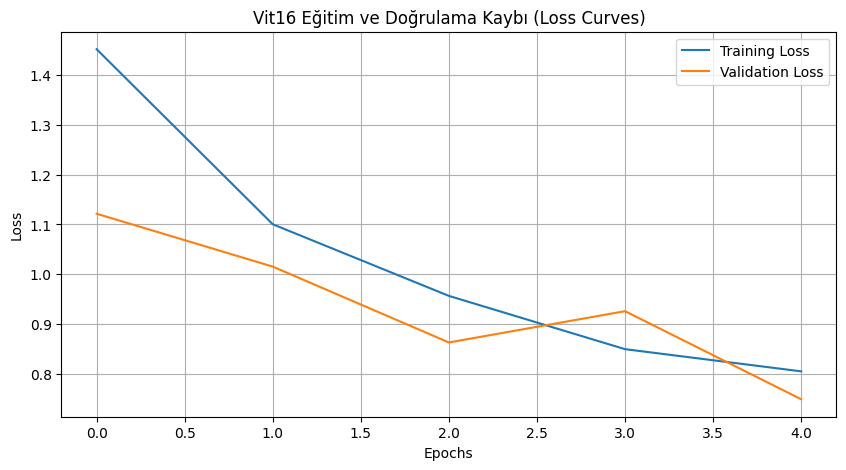

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(vit_train_losses, label='Training Loss')
plt.plot(vit_val_losses, label='Validation Loss')
plt.title('Vit16 Eğitim ve Doğrulama Kaybı (Loss Curves)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

--- Vision Transformer (ViT) Test Seti Performans Analizi ---
ViT ile Test seti üzerinde tahmin yapılıyor...

>>> ViT (Vision Transformer) Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

       akiec       0.35      0.81      0.49        32
         bcc       0.51      0.79      0.62        52
         bkl       0.54      0.61      0.57       110
          df       0.47      0.82      0.60        11
         mel       0.38      0.62      0.47       112
          nv       0.96      0.72      0.82       671
        vasc       0.72      0.93      0.81        14

    accuracy                           0.71      1002
   macro avg       0.56      0.76      0.62      1002
weighted avg       0.80      0.71      0.73      1002



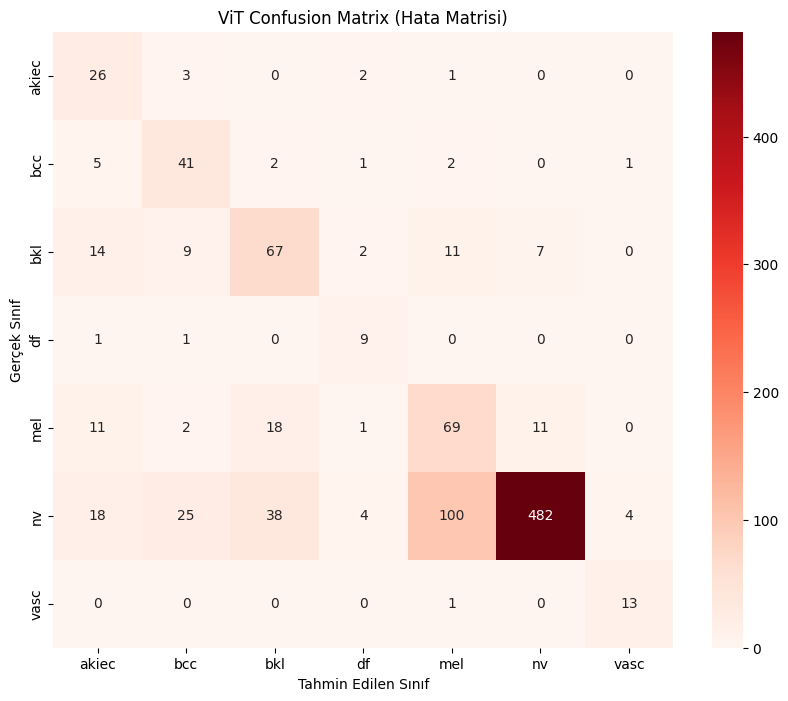

In [8]:
print("--- Vision Transformer (ViT) Test Seti Performans Analizi ---")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. ViT Modelini Değerlendirme Moduna Al
model_vit.eval()
y_true_vit = []
y_pred_vit = []

# 3. Tahminleri Topla
print("ViT ile Test seti üzerinde tahmin yapılıyor...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # DİKKAT: Burada model_vit kullanıyoruz
        outputs = model_vit(inputs)
        _, preds = torch.max(outputs, 1)

        y_true_vit.extend(labels.cpu().numpy())
        y_pred_vit.extend(preds.cpu().numpy())

# 4. Raporu Yazdır
print("\n>>> ViT (Vision Transformer) Detaylı Sınıflandırma Raporu:")
print(classification_report(y_true_vit, y_pred_vit, target_names=CLASSES))

# 5. Confusion Matrix Çiz
cm_vit = confusion_matrix(y_true_vit, y_pred_vit)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Reds', xticklabels=CLASSES, yticklabels=CLASSES) # Rengi karışmasın diye Kırmızı yaptım
plt.title('ViT Confusion Matrix (Hata Matrisi)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()